In [116]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
# from common_imports import *
from helper import simulate_blobs, split_valid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np

def exp_decay(epoch):
    initial_lr = 0.01
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 150, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 100, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=exp_decay(0),momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [118]:
raw_data = pd.read_csv("data/ADNI_CN_AD.csv", index_col=0)
original_data = raw_data.drop(columns=["label"])
raw_labels = raw_data["label"]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 2 to 142
Columns: 149 entries, G_and_S_frontomargin_TH_lh to label
dtypes: float64(148), object(1)
memory usage: 89.1+ KB


In [119]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(dtype=int)
training_labels = oe.fit_transform(raw_labels.values.reshape(-1,1))
training_labels = pd.DataFrame(training_labels)
oe.categories_

[array(['AD', 'CN'], dtype=object)]

In [120]:
original_data.shape

(76, 148)

In [121]:
# pd.DataFrame(training_labels)
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               22350     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [122]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [123]:
# y_train

In [124]:
if __name__ == "__main__":

    # Separating a hold out set that will be used for validation later
    X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

    pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid])
    
    pipeline.train_model(batch_size=20,epochs=5, cross_validation=True, parallel=False)

Running Serial Crossvalidation
Running worker: 0
Prediction Accuracy
8/8 [==============================] - 0s 10ms/step
Scores on data set: loss=9.679 accuracy=0.8750
Fold Correct: 2
Finished training Fold: 0 -> Loss:9.679, Acc:0.8750
Running worker: 1
Prediction Accuracy
8/8 [==============================] - 0s 104us/step
Scores on data set: loss=9.581 accuracy=0.7500
Fold Correct: 3
Finished training Fold: 1 -> Loss:9.581, Acc:0.7500
Running worker: 2
Prediction Accuracy
8/8 [==============================] - 0s 83us/step
Scores on data set: loss=9.818 accuracy=0.7500
Fold Correct: 5
Finished training Fold: 2 -> Loss:9.818, Acc:0.7500
Running worker: 3
Prediction Accuracy
7/7 [==============================] - 0s 78us/step
Scores on data set: loss=9.580 accuracy=0.7143
Fold Correct: 4
Finished training Fold: 3 -> Loss:9.580, Acc:0.7143
Running worker: 4
Prediction Accuracy
7/7 [==============================] - 0s 91us/step
Scores on data set: loss=9.660 accuracy=0.8571
Fold Correc

In [104]:
# [True,True,False].count(True)
np.array([True,True,False, True, False]).sum()


3

Creating data...
Running Serial Crossvalidation
Running worker: 0
Prediction Accuracy
100/100 [==============================] - 0s 36us/step
Scores on data set: loss=0.577 accuracy=1.0000
Fold Correct: 100
Finished training Fold: 0 -> Loss:0.577, Acc:1.0000
Running worker: 1
Prediction Accuracy
100/100 [==============================] - 0s 37us/step
Scores on data set: loss=0.581 accuracy=1.0000
Fold Correct: 100
Finished training Fold: 1 -> Loss:0.581, Acc:1.0000
Running worker: 2
Prediction Accuracy
100/100 [==============================] - 0s 32us/step
Scores on data set: loss=0.575 accuracy=1.0000
Fold Correct: 100
Finished training Fold: 2 -> Loss:0.575, Acc:1.0000
Running worker: 3
Prediction Accuracy
100/100 [==============================] - 0s 39us/step
Scores on data set: loss=0.573 accuracy=1.0000
Fold Correct: 100
Finished training Fold: 3 -> Loss:0.573, Acc:1.0000
Running worker: 4
Prediction Accuracy
100/100 [==============================] - 0s 37us/step
Scores on data

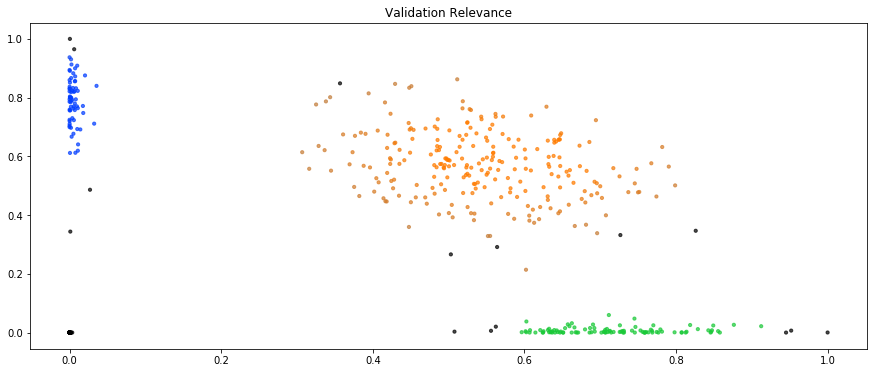

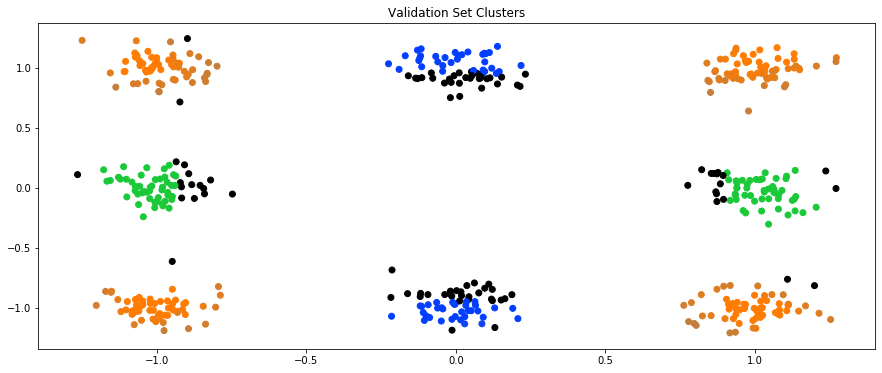

In [17]:


predictions, DNNs = pipeline.get_predictions()
pipeline.train_clusterer(class_label=0, plot=False)
samples, cluster_labels = pipeline.get_validation_clusters()

In [17]:
if __name__ == "__main__":
    from sklearn.svm import LinearSVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import cross_val_score
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    import numpy as np


    original_val_samples = pipeline.val_set.features[pipeline.val_pred_mask]
    original_val_labels = pipeline.val_set.labels[pipeline.val_pred_mask]

    svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}))
    ])
    _score = cross_val_score(svm_clf, X = original_val_samples, y=original_val_labels, cv=10)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    center_class = original_val_samples[original_val_labels == 1]
    target_class = original_val_samples[original_val_labels == 0]
    center_labels = [-1]* len(original_val_labels[original_val_labels == 1])

    # Separate training set for each class with
    # equal amounts of subcluster and center blob
    xtrain = {}
    start = 0
    for i in range(0,cluster_labels.max()+1):
        
        _subclass = target_class[cluster_labels == i]
        _labels = cluster_labels[ cluster_labels == i]
        
        end = start+len(_subclass)
        _xtrain = np.concatenate((center_class[start:end], _subclass))
        _ytrain = np.concatenate((center_labels[start:end], _labels))
        
        xtrain[i] = (_xtrain, _ytrain)
        start += len(_subclass)
    # print(xtrain)
    scores = []
    sizes = [len(xtrain[i][1]) for i in xtrain]

    for i in xtrain:
        print("\tSubcluster",i)
        print("Size:", sizes[i] )
        
        _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
        
    #     %time svm_clf.fit(_xtrain, _ytrain)
        scores.append(_score)
        print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
        
    print("----------------------")
    # subcluster_avg = np.mean([s.mean() for s in scores])
    # print("Mean Score: {:0.4f}".format(subcluster_avg))

    # This is actually the "true" mean: sum(correctly classified) / (total samples)
    weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes,scores)])/sum(sizes)
    print("Weighted Mean: {:0.4f}".format(weighted_avg))


SVM Accuracy: 0.667(+/- 0.045)
	Subcluster 0
Size: 564
SVM Accuracy: 0.764(+/- 0.063)
	Subcluster 1
Size: 140
SVM Accuracy: 1.000(+/- 0.000)
	Subcluster 2
Size: 402
SVM Accuracy: 0.843(+/- 0.096)
	Subcluster 3
Size: 240
SVM Accuracy: 0.842(+/- 0.122)
----------------------
Weighted Mean: 0.8260
